First, a few functions to gather the data from the Nektar output

In [49]:
using DataFrames, Base.Test, Glob, Query

function benchmark_info(filename::String)
    regex = match(r"(gcp|cosma)/swift_(\d+)_(\d+)/out", filename)
    platform = Symbol(regex.captures[1])
    nodes = parse(Int64, regex.captures[2])
    ppn = parse(Int64, regex.captures[3])
    platform, nodes, ppn
end

function benchmark_data(filename::String)
    @assert isfile(filename)
    regex = r"\[\d+\]\s*\[(\d+\.\d+)\] main: done\. Bye\."
    time = Float64[]
    open(filename) do file
        for line in eachline(file)
            capture = match(regex, line)
            capture == nothing && continue
            push!(time, parse(Float64, capture.captures[1]))
        end
    end
    length(time) == 0 && return nothing
    platform, nnodes, nprocs = benchmark_info(filename)
    DataFrame(:time => time,
              :nodes => nnodes, :ppn => nprocs, :n => nnodes * nprocs,
              :platform => platform)
end

function gather_data(files)
    result = benchmark_data(files[1])
    
    for filename in files[2:end]
        data = benchmark_data(filename)
        if data !== nothing
            result = [result; data]
        end
    end
    categorical!(result, :platform)
    result
end

@testset "opening file" begin
    filename = "gcp/swift_8_1/out"
    
    @test benchmark_info(filename)[1] == :gcp
    @test benchmark_info(filename)[2] == 8
    @test benchmark_info(filename)[3] == 1
   
    regex = r"\[\d+\]\s*\[(\d+\.\d+)\] main: done\. Bye\."
    line = "[0000] [09856.9] main: done. Bye."
    @test match(regex, line) != nothing
    @test match(regex, line).captures[1] == "09856.9"
    data = benchmark_data(filename)
    @test nrow(data) == 1
    @test all(data[:nodes] .== 8)
    @test all(data[:ppn] .== 1)
    @test all(data[1, :time] .≈ 9856.9)
end


Test Summary: | Pass  Total
opening file  |    9      9


Base.Test.DefaultTestSet("opening file", Any[], 9, false)

Then we actually gather the data, and compute the speedup vs the code running on Cosma with a single process.

In [68]:
data = gather_data(glob([r"(gcp|cosma)", r"swift_\d+_\d+", "out"]))
means = @from r in data begin
    @group r by (r.n, r.nodes, r.ppn, r.platform) into g
    @select {n=g.key[1], nodes=g.key[2],
             ppn=g.key[3], platform=g.key[4],
             mean=mean(g..time)}
    @collect DataFrame
end
serial = first(means[(means[:nodes] .== 8) .& (means[:ppn] .== 1) .& (means[:platform] .== :cosma), :mean])
speedup = means
speedup[:speedup] = serial ./ speedup[:mean]
speedup

,n,nodes,ppn,platform,mean,speedup
1,16,16,1,:cosma,2376.7,1.65145
2,32,32,1,:cosma,1751.2,2.24132
3,64,32,2,:cosma,1375.4,2.85372
4,8,8,1,:cosma,3925.0,1.0
5,16,8,2,:cosma,2759.6,1.42231
6,16,16,1,:gcp,7979.5,0.491885
7,32,16,2,:gcp,7717.0,0.508617
8,4,4,1,:gcp,12439.8,0.31552
9,8,4,2,:gcp,15699.5,0.250008
10,8,8,1,:gcp,9856.9,0.398198


We can now create the plot

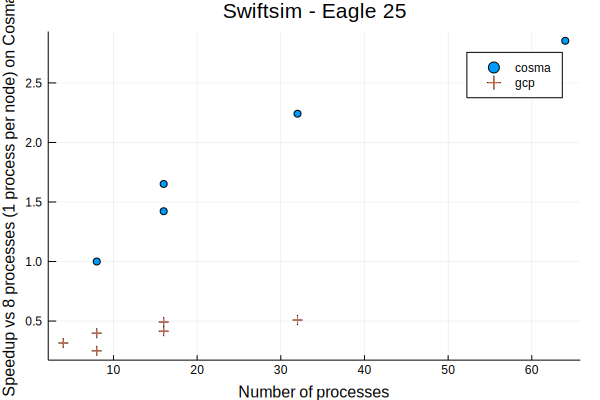

In [75]:
using StatPlots, GR
gr()
swift = @df speedup StatPlots.scatter(
        :n, :speedup, group=:platform,
        markershape=ifelse.(:platform .== :gcp, :cross, :circle))

title!(swift, "Swiftsim - Eagle 25")
xlabel!(swift, "Number of processes")
ylabel!(swift, "Speedup vs 8 processes (1 process per node) on Cosma")
Plots.savefig(swift, "benchmarks.png")
swift

In [71]:
speedup

,n,nodes,ppn,platform,mean,speedup
1,16,16,1,:cosma,2376.7,1.65145
2,32,32,1,:cosma,1751.2,2.24132
3,64,32,2,:cosma,1375.4,2.85372
4,8,8,1,:cosma,3925.0,1.0
5,16,8,2,:cosma,2759.6,1.42231
6,16,16,1,:gcp,7979.5,0.491885
7,32,16,2,:gcp,7717.0,0.508617
8,4,4,1,:gcp,12439.8,0.31552
9,8,4,2,:gcp,15699.5,0.250008
10,8,8,1,:gcp,9856.9,0.398198
